# 5.이미지 분류
## 5.1 개/고양이 예를 반려동물 품종으로 확장하기

In [1]:
# load dataset
from fastai.vision.all import *
path = untar_data(URLs.PETS)

path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [2]:
(path/"images").ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_31.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/samoyed_153.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_setter_176.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_194.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_140.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_86.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_23.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Bombay_76.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_26.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/havanese_39.jpg')...]

In [3]:
# test one file
fname = (path/"images").ls()[0]
re.findall(r"(.+)_\d+.jpg$", fname.name)  # 하나 이상의 숫자와 확장자 이전의 모든 문자 

['British_Shorthair']

In [4]:
# DataBlock
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r"(.+)_\d+.jpg$"), "name"),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [5]:
# item_tfms=Resize(460)  # 전체 너비나 높이를 기준으로 잘라내는 단계
# batch_tfms=aug_transforms(size=224, min_scale=0.75)  # 임의의 부분을 잘라낸 후 증강하는 단계

## 5.2 사전 크기 조절

- 이미지 증강 결과 확인 후 기본 모델로 빠르게 테스트를 권장함

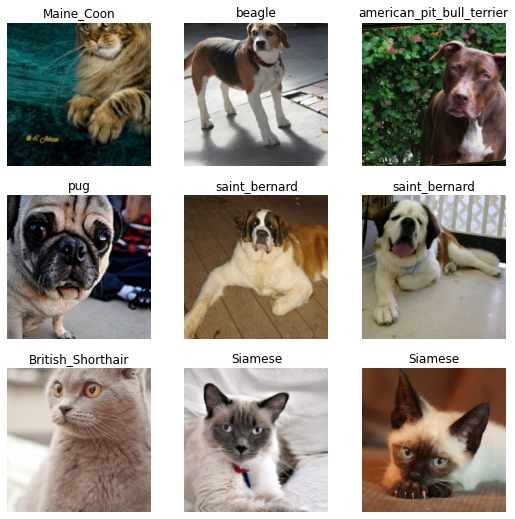

In [6]:
dls.show_batch(nrows=3, ncols=3)

In [7]:
# 이미지 크기를 조절하는 부분이 빠진 경우 등 summary를 통해서 확인 가능
# error 출력 사례
pets_error = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_items=get_image_files,
                       splitter=RandomSplitter(seed=42),
                       get_y=using_attr(RegexLabeller(r"(.+)_\d+.jpg$"), "name"))

# pets_error.summary(path/"images")  # will raise a error

In [8]:
# 기본 모델 사용을 통한 학습 검증
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.522250,0.336057,0.107578,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.511944,0.317479,0.096076,00:26
1,0.321409,0.212158,0.073072,00:26


## 5.3 교차 엔트로피 손실

- 종속 변수에 범주가 둘 이상이더라도 작동
- 더 빠르고 안정적인 학습 결과

In [9]:
x, y = dls.one_batch()
y  # 배치 크기는 64

TensorCategory([30,  3, 25, 18,  1, 21,  8, 33, 23, 26, 10, 33, 27,  9, 13, 34, 23, 19,
        27,  6,  4, 15,  5, 17, 27, 12, 20, 18, 22,  9, 34,  2, 30, 24,  0, 10,
        18, 23, 29, 36, 30,  1, 25,  5, 22,  1,  8,  3,  9, 13,  2, 31,  8,  3,
        13,  2, 15, 13,  0, 35, 34, 16, 23, 22], device='cuda:0')

In [10]:
preds, _ = learn.get_preds(dl=[(x, y)])
preds[0]  # 예측 결과의 첫 줄만 확인

TensorBase([1.7690e-05, 1.0789e-05, 2.2397e-05, 1.2072e-05, 3.0160e-06, 6.4152e-06,
        2.4976e-06, 5.6498e-06, 3.6512e-07, 2.7384e-06, 1.9595e-06, 4.8260e-06,
        1.8353e-04, 4.5991e-05, 2.3250e-02, 1.0150e-02, 4.8266e-04, 7.9577e-06,
        7.7724e-06, 6.5739e-06, 1.6068e-05, 3.6134e-05, 8.3380e-06, 1.6342e-04,
        3.8400e-06, 1.8060e-04, 2.6172e-06, 6.6855e-06, 2.1555e-06, 7.1445e-06,
        9.6528e-01, 4.5631e-06, 1.3164e-06, 7.6531e-06, 4.6418e-06, 1.2792e-05,
        3.3118e-05])

In [11]:
len(preds[0]), preds[0].sum().item()  # 모든 클래스의 확률합은 1

(37, 1.0)

### softmax

In [12]:
acts = torch.randn((6, 2)) * 2
acts

tensor([[-0.9916, -2.2545],
        [ 0.1560, -1.9368],
        [-0.6164,  1.1047],
        [-2.0798, -2.1778],
        [ 1.6429, -3.7728],
        [-1.2445, -2.9512]])

In [13]:
acts.sigmoid()

tensor([[0.2706, 0.0950],
        [0.5389, 0.1260],
        [0.3506, 0.7511],
        [0.1111, 0.1018],
        [0.8379, 0.0225],
        [0.2237, 0.0497]])

In [14]:
(acts[:, 0] - acts[:, 1]).sigmoid()  # (1)

tensor([0.7795, 0.8902, 0.1517, 0.5245, 0.9956, 0.8464])

In [15]:
def softmax(x):
    return exp(x) / exp(x).sum(dim=1, keepdim=True)

In [16]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts   # (1)의 숫자 3일 확률과 동일

tensor([[0.7795, 0.2205],
        [0.8902, 0.1098],
        [0.1517, 0.8483],
        [0.5245, 0.4755],
        [0.9956, 0.0044],
        [0.8464, 0.1536]])

### Negative log likelihood

In [17]:
def mnist_loss(inputs, targets):
    inputs = inputs.sigmoid()
    return torch.where(targets==1, 1-inputs, inputs).mean()

In [18]:
targ = tensor([0, 1, 0, 1, 1, 0])
targ

tensor([0, 1, 0, 1, 1, 0])

In [19]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.7795, 0.1098, 0.1517, 0.4755, 0.0044, 0.8464])

In [20]:
sm_acts

tensor([[0.7795, 0.2205],
        [0.8902, 0.1098],
        [0.1517, 0.8483],
        [0.5245, 0.4755],
        [0.9956, 0.0044],
        [0.8464, 0.1536]])

In [21]:
-sm_acts[idx, targ]

tensor([-0.7795, -0.1098, -0.1517, -0.4755, -0.0044, -0.8464])

In [22]:
F.nll_loss(sm_acts, targ, reduction="none")  # 위의 행위를 한 줄로 설명

tensor([-0.7795, -0.1098, -0.1517, -0.4755, -0.0044, -0.8464])

### Cross entropy loss
- log(negative log likelihood)
- 작은 수의 곱셈을 덧셈으로 변환해서 연산을 쉽게 변환
- 파이토치의 모든 손실 함수는 클래스 형식과 F 네임스페이스의 일반 함수, 2가지 방식을 제공
- 단, 클래스 형식을 선호함

In [23]:
loss_func = nn.CrossEntropyLoss()
loss_func(acts, targ)

tensor(1.7790)

In [24]:
F.cross_entropy(acts, targ)

tensor(1.7790)

In [25]:
# reduce = "none" : 평균 손실(기본값)이 아닌 개별 손실을 반환함
nn.CrossEntropyLoss(reduction="none")(acts, targ)

tensor([0.2491, 2.2091, 1.8857, 0.7434, 5.4201, 0.1667])